# Forward Simulation

In this notebook, we compute a single line of AEM data over a conductive plate in a resistive background. We plot the currents and magnetic fields in the subsurface. 

This notebook generates Figures 1-4 in: 

Heagy, L., Kang, S., Cockett, R., and Oldenburg, D., 2018, _Open source software for simulations and inversions of airborne electromagnetic data_, AEM 2018 International Workshop on Airborne Electromagnetics 

In [1]:
from SimPEG import EM, Mesh, Utils
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation, collections
from pymatsolver import Pardiso

import ipywidgets 
from IPython.display import HTML

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 16

## Create a Tensor Mesh

Here, we build a 3D Tensor mesh to run the forward simulation on. 

In [3]:
cs, ncx, ncy, ncz, npad = 50., 20, 1, 20, 10
pad_rate = 1.3
hx = [(cs,npad,-pad_rate), (cs,ncx), (cs,npad,pad_rate)]
hy = [(cs,npad,-pad_rate), (cs,ncy), (cs,npad,pad_rate)]
hz = [(cs,npad,-pad_rate), (cs,ncz), (cs,npad,pad_rate)]
mesh = Mesh.TensorMesh([hx,hy,hz], 'CCC')

In [4]:
print (mesh)

  ---- 3-D TensorMesh ----  
   x0: -3270.27
   y0: -2795.27
   z0: -3270.27
  nCx: 40
  nCy: 21
  nCz: 40
   hx: 689.29,  530.22,  407.87,  313.74,  241.34,  185.65,  142.81,  109.85,  84.50,  65.00,  20*50.00,  65.00,  84.50,  109.85,  142.81,  185.65,  241.34,  313.74,  407.87,  530.22,  689.29,
   hy: 689.29,  530.22,  407.87,  313.74,  241.34,  185.65,  142.81,  109.85,  84.50,  65.00,  50.00,  65.00,  84.50,  109.85,  142.81,  185.65,  241.34,  313.74,  407.87,  530.22,  689.29,
   hz: 689.29,  530.22,  407.87,  313.74,  241.34,  185.65,  142.81,  109.85,  84.50,  65.00,  20*50.00,  65.00,  84.50,  109.85,  142.81,  185.65,  241.34,  313.74,  407.87,  530.22,  689.29,


In [5]:
# print diffusion distance and make sure mesh padding goes beyond that
print(1207*np.sqrt(1e3*2.5*1e-3))
print(mesh.hx[-10:].sum())

1908.434567911617
2770.267323395001


## Build a model

In [6]:
# model parameters
sig_air = 1e-8
sig_half = 1e-3
sig_plate = 1e-1

In [7]:
# put the omdel on the mesh 
blk1 = Utils.ModelBuilder.getIndicesBlock(
    np.r_[-49.5, 500, -50],
    np.r_[50, -500, -450], 
    mesh.gridCC
)

sigma = np.ones(mesh.nC)*sig_air
sigma[mesh.gridCC[:,2]<0.] = sig_half
sigma_half = sigma.copy()
sigma[blk1] = sig_plate

In [8]:
xref = 0
zref = -100.
yref = 0.

xlim = [-700., 700.]
ylim = [-700., 700.]

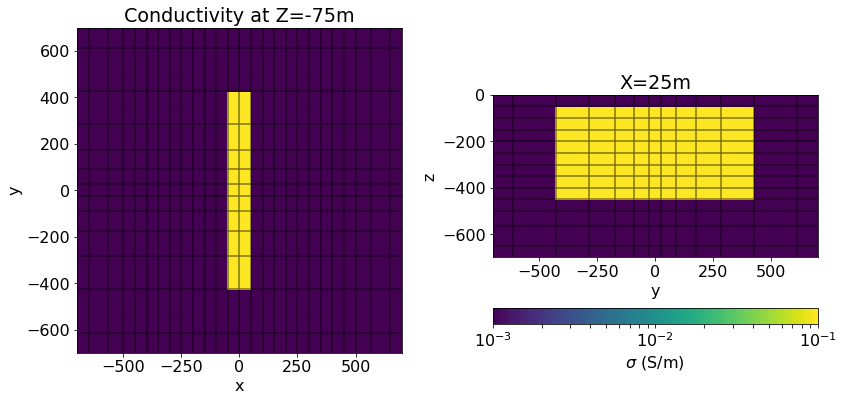

In [40]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

indx = np.argmin(abs(mesh.vectorCCx-xref))
indy = np.argmin(abs(mesh.vectorCCy-yref))
indz = np.argmin(abs(mesh.vectorCCz-zref))

dat1 = mesh.plotSlice(sigma, grid = True, ax = ax[0], ind = 15, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))
dat2 = mesh.plotSlice(sigma, grid = True, ax = ax[1],normal='X', pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))

cb = plt.colorbar(dat2[0], orientation="horizontal", ax = ax[1])

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim[0], 0.)

plt.tight_layout()

ax[0].set_aspect(1)
ax[1].set_aspect(1)

ax[0].set_title(("Conductivity at Z=%.0fm")%(mesh.vectorCCz[indz]))
ax[1].set_title(("X=%.0fm")%(mesh.vectorCCx[indx]))

cb.set_label("$\sigma$ (S/m)")

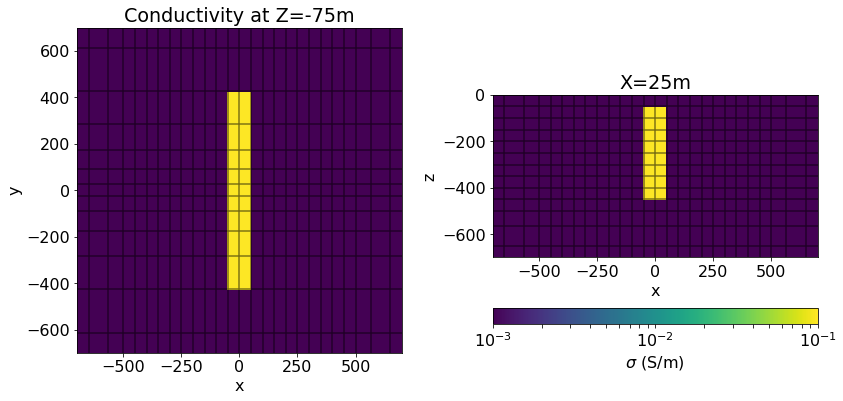

In [41]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))

indx = np.argmin(abs(mesh.vectorCCx-xref))
indy = np.argmin(abs(mesh.vectorCCy-yref))
indz = np.argmin(abs(mesh.vectorCCz-zref))

dat1 = mesh.plotSlice(sigma, grid = True, ax = ax[0], ind = 15, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))
dat2 = mesh.plotSlice(sigma, grid = True, ax = ax[1],normal='Y', pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))

cb = plt.colorbar(dat2[0], orientation="horizontal", ax = ax[1])

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim[0], 0.)

plt.tight_layout()

ax[0].set_aspect(1)
ax[1].set_aspect(1)

ax[0].set_title(("Conductivity at Z=%.0fm")%(mesh.vectorCCz[indz]))
ax[1].set_title(("X=%.0fm")%(mesh.vectorCCx[indx]))

cb.set_label("$\sigma$ (S/m)")

## Assemble the survey

In [11]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-450, mesh.vectorCCx<450)]
# np.save("x", x)

In [12]:
%%time

# assemble the sources and receivers
time = np.logspace(np.log10(5e-5), np.log10(2.5e-3), 21)
srcList = []

for xloc in x:
    location = np.array([[xloc, 0., 30.]])
    rx_z = EM.TDEM.Rx.Point_dbdt(location, time, 'z')
    rx_x = EM.TDEM.Rx.Point_dbdt(location, time, 'x')
    src = EM.TDEM.Src.CircularLoop([rx_z, rx_x], orientation='z', loc=location)
    srcList.append(src)

CPU times: user 10.8 ms, sys: 1.99 ms, total: 12.8 ms
Wall time: 12.4 ms


In [13]:
len(time)

21

## Solve the forward simulation

In [14]:
%%time
prb = EM.TDEM.Problem3D_b(mesh, sigma=sigma, Solver=Pardiso, verbose=True)
survey = EM.TDEM.Survey(srcList)
prb.timeSteps = [(1e-05, 15), (5e-5, 10), (2e-4, 10)]
survey.pair(prb)
f = prb.fields([])

/Users/lindseyjh/git/python_symlinks/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-05)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 5.000000e-05)
Done
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    Done...
    Solving...   (tInd = 2

# Compute the fields

In [47]:
xyzlim = np.array([[-700, 700], [-700, 700], [-700, 0]])

actind_core, mesh_core = Utils.ExtractCoreMesh(xyzlim, mesh)

indx = np.argmin(abs(mesh_core.vectorCCx-xref))
indy = np.argmin(abs(mesh_core.vectorCCy-yref))
indz = np.argmin(abs(mesh_core.vectorCCz-zref))

Pex = mesh.getInterpolationMat(mesh_core.gridCC, 'Ex')
Pey = mesh.getInterpolationMat(mesh_core.gridCC, 'Ey')
Pez = mesh.getInterpolationMat(mesh_core.gridCC, 'Ez')

Pfx = mesh.getInterpolationMat(mesh_core.gridCC, 'Fx')
Pfy = mesh.getInterpolationMat(mesh_core.gridCC, 'Fy')
Pfz = mesh.getInterpolationMat(mesh_core.gridCC, 'Fz')

In [48]:
def getj_from_f(src, f, actind_core):
    ex = Pex*(f[src, 'e'])
    ey = Pey*(f[src, 'e'])
    ez = Pez*(f[src, 'e'])
    jx = Utils.sdiag(sigma[actind_core])*ex
    jy = Utils.sdiag(sigma[actind_core])*ey
    jz = Utils.sdiag(sigma[actind_core])*ez   
    return jx, jy, jz

def getb_from_f(src, f, actind_core):
    bx = Pfx*(f[src, 'b'])
    by = Pfy*(f[src, 'b'])
    bz = Pfz*(f[src, 'b'])   
    return bx, by, bz

In [49]:
def viz_currents(itime, iSrc, clim=None, ax=None, showcb=True, showit=True):
    if ax is None: 
        fig, ax = plt.subplots(1,2, figsize = (16,8))
    
    location  = srcList[iSrc].loc
    
    jx, jy, jz = getj_from_f(srcList[iSrc], f, actind_core)
    temp = np.r_[jx[:,itime], jy[:,itime], jz[:,itime]]
#     temp = f[srcList[iSrc], 'j', itime]

    dat1 = mesh_core.plotSlice(
        temp, normal='X', ind=int(indx), vType='CCv', view='vec', ax=ax[1], 
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'}, 
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    dat2 = mesh_core.plotSlice(
        temp, normal='Z', ind=int(indz), vType='CCv', view='vec', ax=ax[0], 
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    ax[0].plot(location[0,0], location[0,1], 'go', ms=20)
    ax[0].text(-600, 500, ("Time: %.2f ms")%(prb.times[itime]*1e3), color='w', fontsize=20)
    
    if showcb is True: 
        cb = plt.colorbar(dat1[0], orientation="horizontal", ax = ax[1])
        cb.set_label("Current density (A/m$^2$)")
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    ax[0].set_title(("Current density at Z=%.0fm")%(mesh_core.vectorCCz[indz]))
    ax[1].set_title(("X=%.0fm")%(mesh_core.vectorCCx[indx]))
    
    if showit: 
        plt.show()
    
    return [d for d in dat1 + dat2]

## View the current density through time

In [50]:
ipywidgets.interact(
    viz_currents,
    itime = ipywidgets.IntSlider(min=1, max=len(prb.times), value=1),
    iSrc = ipywidgets.IntSlider(min=0, max=len(srcList), value=5),
    clim = ipywidgets.fixed([3e-13, 2e-9]),
    ax=ipywidgets.fixed(None), 
    showit=ipywidgets.fixed(True),
    showcb=ipywidgets.fixed(True)
)


interactive(children=(IntSlider(value=1, description='itime', max=36, min=1), IntSlider(value=5, description='iSrc', max=18), Output()), _dom_classes=('widget-interact',))

<function __main__.viz_currents>

## Movie of the currents

Movies shown in the presentation. It is slow to build these, so by default we won't. Change `make_movie` to `True` to build the movies

In [55]:
make_movie = True
save_mp4 = False

/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:973: UserWarning: Animation size has reached 21318716 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
  " will be dropped.".format(self))


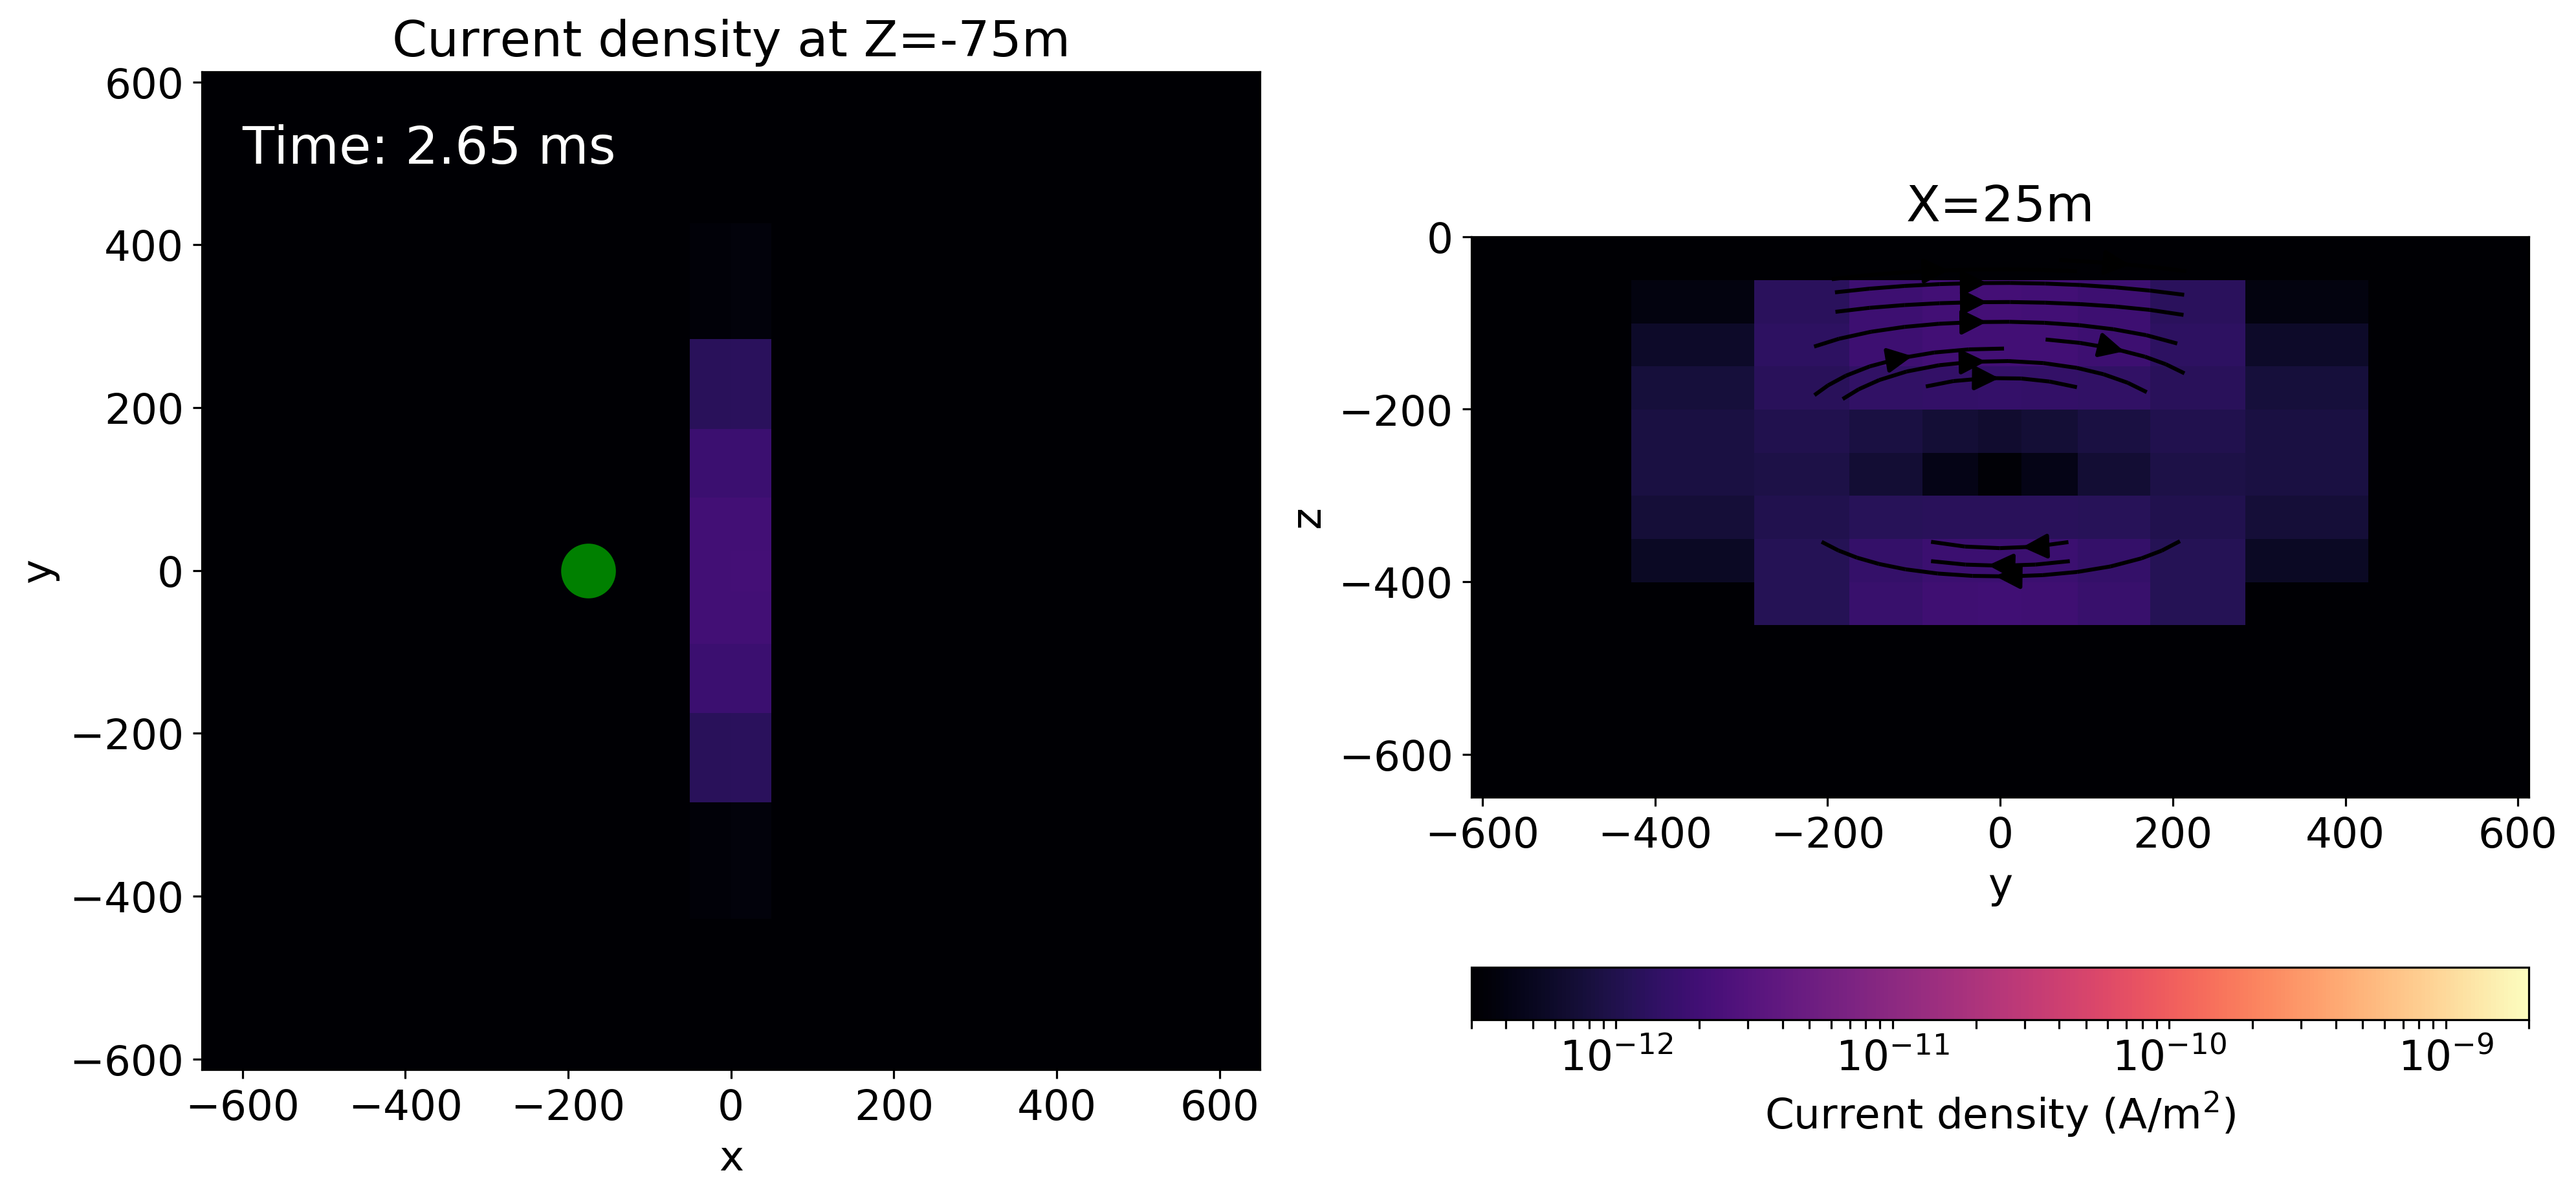

In [56]:
iSrc = 5

if make_movie: 

    fig, ax = plt.subplots(1,2, figsize = (16,8), dpi=290)
    out = viz_currents(itime=1, iSrc=iSrc, clim=[3e-13, 2e-9], ax=ax, showcb=True, showit=False)

    def init():
        [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
        return out

    def update(t):
        for a in ax:
            a.patches = []
            a.lines = []
            a.clear()
        return viz_currents(itime=t, iSrc=iSrc, clim=[3e-13, 2e-9], ax=ax, showcb=False, showit=False)

    ani = animation.FuncAnimation(fig, update, np.arange(1, len(prb.times)), init_func=init, blit=False)

    anihtml = ani.to_jshtml(fps=7)
    HTML(anihtml)
    
    if save_mp4: 
        ani.save(
            "currents1.mp4", writer="ffmpeg", fps=7, dpi=250, bitrate=0, 
            metadata={"title":"TDEM currents in a plate", "artist":"Lindsey Heagy"}
        )

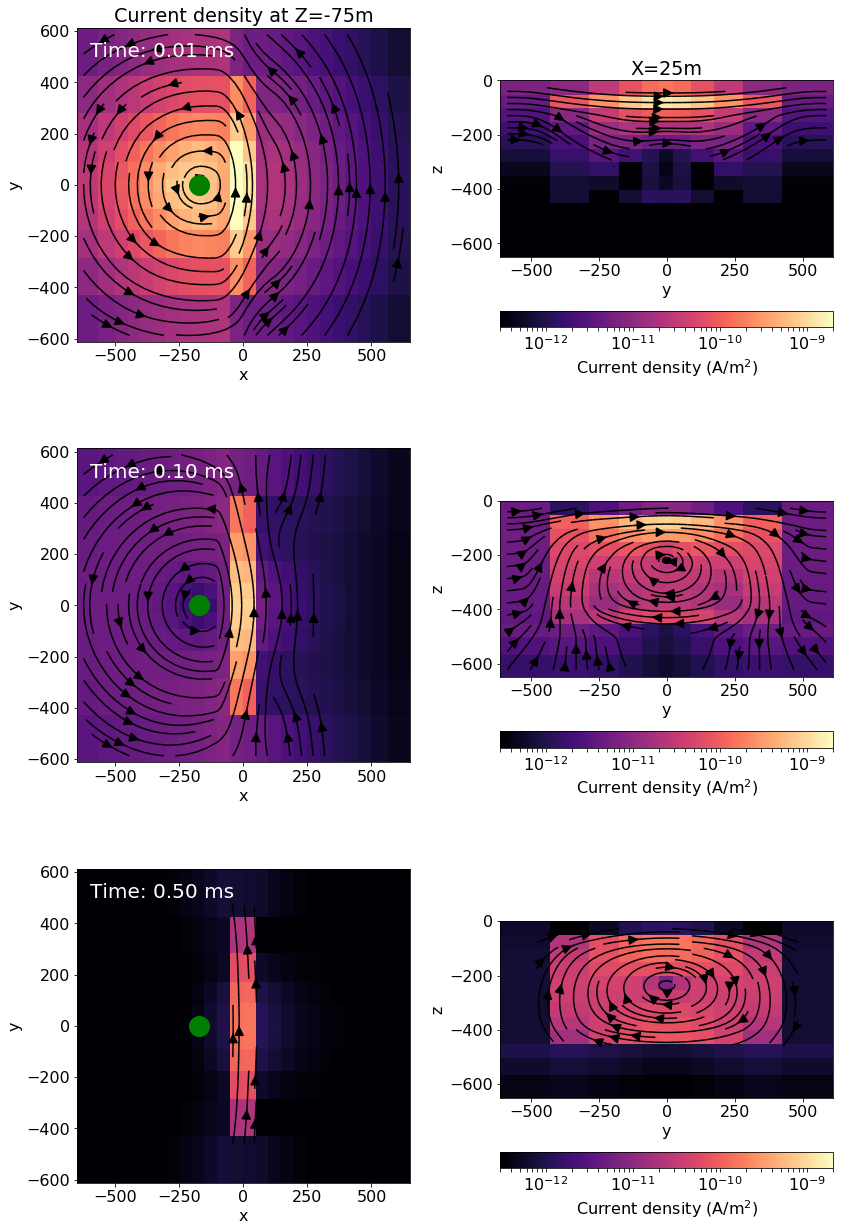

In [59]:
fig, axes = plt.subplots(3,2, figsize = (12,6*3))
 
iSrc = 5
clim = [3e-13, 2e-9]

for i, itime in enumerate([1, 10, 22]):
    
    ax = axes[i, :]
    location  = srcList[iSrc].loc
    
    jx, jy, jz = getj_from_f(srcList[iSrc], f, actind_core)
    temp = np.r_[jx[:,itime], jy[:,itime], jz[:,itime]]

    dat1 = mesh_core.plotSlice(
        temp, normal='X', ind=int(indx), vType='CCv', view='vec', ax=ax[1], 
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'}, 
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    dat2 = mesh_core.plotSlice(
        temp, normal='Z', ind=int(indz), vType='CCv', view='vec', ax=ax[0], 
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    ax[0].plot(location[0,0], location[0,1], 'go', ms=20)
    ax[0].text(-600, 500, ("Time: %.2f ms")%(prb.times[itime]*1e3), color='w', fontsize=20)
    cb = plt.colorbar(dat1[0], orientation="horizontal", ax = ax[1])
    cb.set_label("Current density (A/m$^2$)")
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    
    
    if itime == 1: 
        ax[0].set_title(("Current density at Z=%.0fm")%(mesh_core.vectorCCz[indz]))
        ax[1].set_title(("X=%.0fm")%(mesh_core.vectorCCx[indx]))
    else:
        ax[0].set_title("")
        ax[1].set_title("")

plt.tight_layout()
plt.show()

In [60]:
xyzlim = np.array([[-700, 700], [-700, 700], [-700, 700]])

actind_core2, mesh_core2 = Utils.ExtractCoreMesh(xyzlim, mesh)

indx = np.argmin(abs(mesh_core2.vectorCCx-xref))
indy = np.argmin(abs(mesh_core2.vectorCCy-yref))
indz = np.argmin(abs(mesh_core2.vectorCCz-zref))

Pex2 = mesh.getInterpolationMat(mesh_core2.gridCC, 'Ex')
Pey2 = mesh.getInterpolationMat(mesh_core2.gridCC, 'Ey')
Pez2 = mesh.getInterpolationMat(mesh_core2.gridCC, 'Ez')

Pfx2 = mesh.getInterpolationMat(mesh_core2.gridCC, 'Fx')
Pfy2 = mesh.getInterpolationMat(mesh_core2.gridCC, 'Fy')
Pfz2 = mesh.getInterpolationMat(mesh_core2.gridCC, 'Fz')

In [61]:
def getb_from_f2(src, f, actind_core):
    bx = Pfx2*(f[src, 'b'])
    by = Pfy2*(f[src, 'b'])
    bz = Pfz2*(f[src, 'b'])   
    return bx, by, bz

In [62]:
def viz_magnetic_flux(itime, iSrc, clim=None, ax=None, showcb=True, showit=True):
    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    location  = srcList[iSrc].loc
    
    bx, by, bz = getb_from_f2(srcList[iSrc], f, actind_core2)
    temp = np.r_[bx[:,itime], by[:,itime], bz[:,itime]]
    
    dat1 = mesh_core2.plotSlice(
        temp, normal='Y', ind=int(indy), vType='CCv', view='vec', 
        ax=ax, pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = clim[0] if clim is not None else None
    )

    ax.plot(location[0,0], location[0,2], 'go', ms=15)
    
    ax.text(-600, 500, ("Time: %.2f ms")%(prb.times[itime]*1e3), color='w', fontsize=20)
    
    if showcb: 
        cb = plt.colorbar(dat1[0], ax = ax)
        cb.set_label("Magnetic Flux Density (T)")
    ax.set_aspect(1)
    ax.set_title(("Magnetic Flux Density at Y=%.0fm")%(mesh_core.vectorCCy[indy]))
    
    if showit: 
        plt.show()
    
    return [d for d in dat1 + dat2]

In [63]:
ipywidgets.interact(
    viz_magnetic_flux,
    itime = ipywidgets.IntSlider(min=1, max=len(prb.times), value=1),
    iSrc = ipywidgets.IntSlider(min=0, max=len(srcList), value=5),
    clim = ipywidgets.fixed([1e-17, 3e-14]),
    ax=ipywidgets.fixed(None), 
    showit=ipywidgets.fixed(True),
    showcb=ipywidgets.fixed(True)
)


interactive(children=(IntSlider(value=1, description='itime', max=36, min=1), IntSlider(value=5, description='iSrc', max=18), Output()), _dom_classes=('widget-interact',))

<function __main__.viz_magnetic_flux>

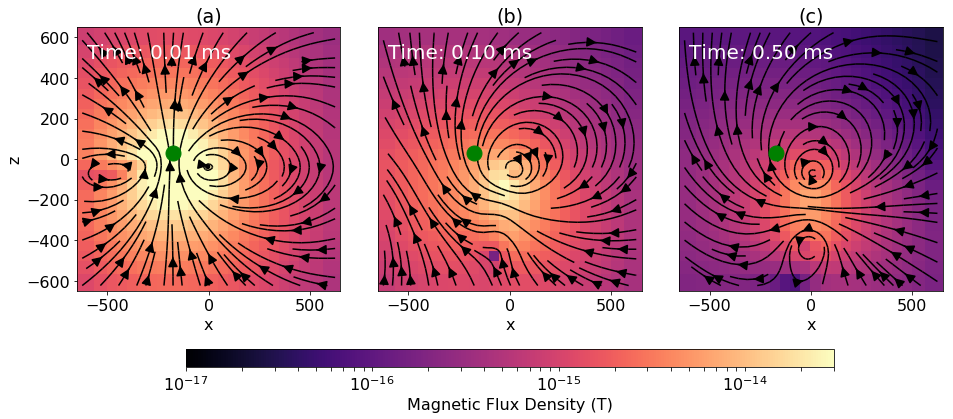

In [64]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))

fig.subplots_adjust(bottom=0.7)

iSrc = 5
clim = [1e-17, 3e-14]

for a, itime, title in zip(ax, [1, 10, 22], ["a", "b", "c"]):
    location  = srcList[iSrc].loc
    
    bx, by, bz = getb_from_f2(srcList[iSrc], f, actind_core2)
    temp = np.r_[bx[:,itime], by[:,itime], bz[:,itime]]
    
    dat1 = mesh_core2.plotSlice(
        temp, normal='Y', ind=int(indy), vType='CCv', view='vec', 
        ax=a, pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = clim[0] if clim is not None else None
    )
        
    if itime > 1:
        a.get_yaxis().set_visible(False)

    a.plot(location[0,0], location[0,2], 'go', ms=15)
    
    a.text(-600, 500, ("Time: %.2f ms")%(prb.times[itime]*1e3), color='w', fontsize=20)
    a.set_aspect(1)
    a.set_title("({})".format(title))
#     a.set_title(("Magnetic Flux Density at Y=%.0fm")%(mesh_core.vectorCCy[indy]))
    

plt.tight_layout()


cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
cb = fig.colorbar(dat1[0], cbar_ax, orientation='horizontal')
cb.set_label('Magnetic Flux Density (T)')

## Movie for magnetic flux

In [65]:
make_movie = True
save_mp4 = True

/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:973: UserWarning: Animation size has reached 21452945 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
  " will be dropped.".format(self))


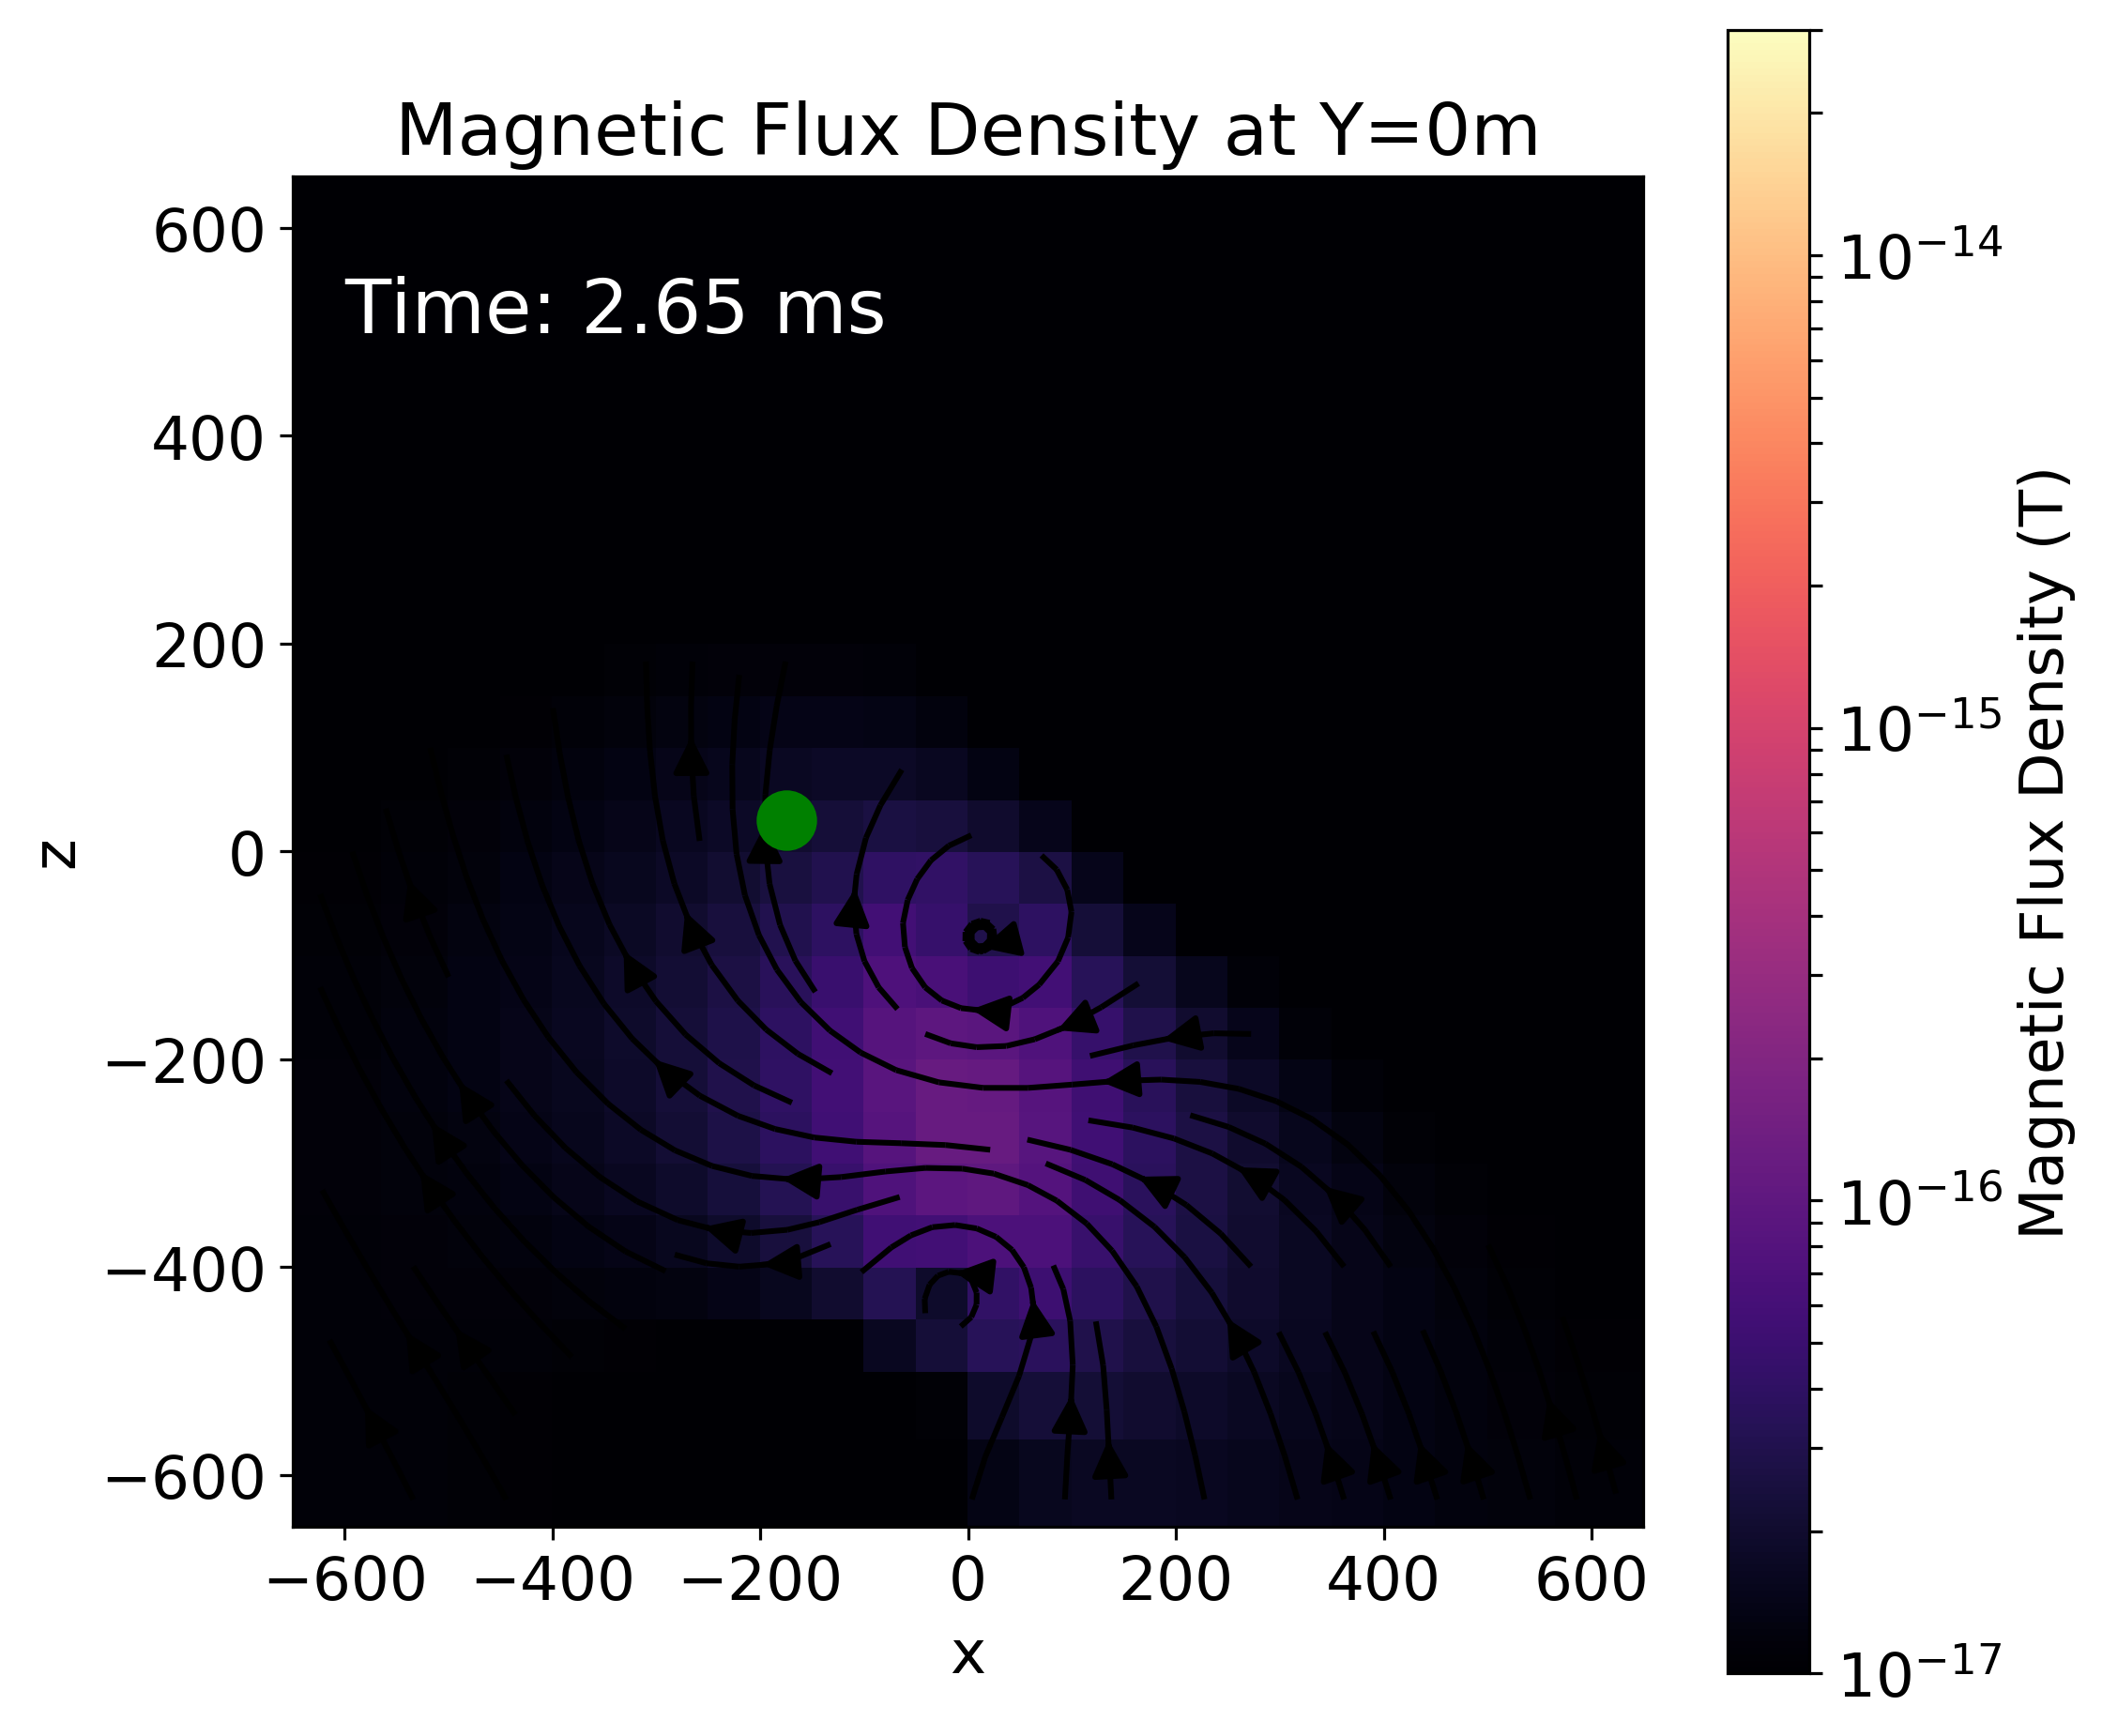

In [68]:
iSrc = 5
clim=[1e-17, 3e-14]

if make_movie: 

    fig, ax = plt.subplots(1, 1, figsize = (8, 8), dpi=290)

    out = viz_magnetic_flux(itime=1, iSrc=iSrc, clim=clim, ax=ax, showcb=True, showit=False)

    def init():
        [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
        return out

    def update(t):
        ax.patches = []
        ax.lines = []
        ax.clear()
        return viz_magnetic_flux(itime=t, iSrc=iSrc, clim=clim, ax=ax, showcb=False, showit=False)

    ani = animation.FuncAnimation(fig, update, np.arange(1, len(prb.times)), init_func=init, blit=False)

    anihtml = ani.to_jshtml(fps=7)
    HTML(anihtml)
    
    if save_mp4: 
        ani.save(
            "magnetic_flux.mp4", writer="ffmpeg", fps=7, dpi=250, bitrate=0, 
            metadata={"title":"TDEM magnetic flux in a plate", "artist":"Lindsey Heagy"}
        )

## Compute predicted data

In [ ]:
dpred = survey.dpred([], f=f)

In [ ]:
DPRED = dpred.reshape((survey.nSrc, 2, rx_z.times.size))

In [ ]:
noise = abs(dpred)*0.05 * np.random.randn(dpred.size) + 1e-14
dobs = dpred + noise

In [ ]:
# # uncomment to save
# np.save("dobs", dobs)
# np.save("dtrue", dpred)

In [ ]:
DOBS = dobs.reshape((survey.nSrc, 2, rx_z.times.size))

In [ ]:
import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.cmap'] = 'viridis'
moment = 13**2 *np.pi / 1e12

In [ ]:
# 0, 1e-4, 4e-4
rx_z.times[[0, 4, 12]]

In [ ]:
srcList[5].loc[0][0] * np.ones(3)

In [ ]:
fig = plt.figure(figsize=(9, 3.5))
for itime in range(rx_z.times.size):
    plt.semilogy(x, -DPRED[:,0,itime], 'k.-', lw=1)
plt.plot(srcList[5].loc[0][0]*np.ones(3), -DPRED[5,0,[0, 4, 12]] , 's', color="C3")
plt.xlabel("x (m)")
plt.ylabel("Voltage (V/Am$^2$)")
plt.grid(which="both", alpha=0.2)